In [1]:
import numpy as np
import pandas as pd 
import os
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,RNN
import math
from sklearn.metrics import mean_squared_error

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/netflix-stock-price-prediction/NFLX.csv


In [2]:
df = pd.read_csv('/kaggle/input/netflix-stock-price-prediction/NFLX.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320703,412.374044,419.000733,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,108.289999,5.465535e+06
min,233.919998,250.649994,231.229996,233.880005,233.880005,1.144000e+06
25%,331.489990,336.299988,326.000000,331.619995,331.619995,4.091900e+06
50%,377.769989,383.010010,370.880005,378.670013,378.670013,5.934500e+06
75%,509.130005,515.630005,502.529999,509.079987,509.079987,9.322400e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,5.890430e+07


In [5]:
a =df['Date'].min()
b =df['Date'].max()
d1 = datetime.strptime(b, "%Y-%m-%d")
d2 = datetime.strptime(a, "%Y-%m-%d")

delta = d2 - d1
print(f'Difference is {delta.days} days')


Difference is -1460 days


In [6]:
df['Date'].nunique()

1009

In [7]:
df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [8]:
df = df.resample('D').ffill().reset_index()
df['Date'].nunique()

1461

In [9]:
df1 = df[['Close']]
df1

,Close
0,254.259995
1,265.720001
2,264.559998
3,250.100006
4,249.470001
...,...
1456,427.140015
1457,457.130005
1458,429.480011
1459,405.600006


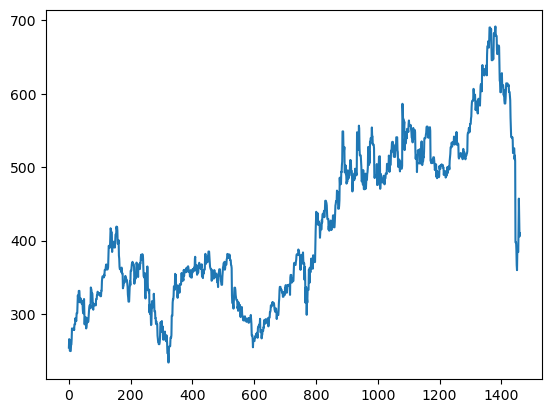

In [10]:
plt.plot(df1)

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
df1.shape

(1461, 1)

In [14]:
training_size = int(len(df1)*0.7)
test_size = len(df1)-training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [15]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [17]:
print(X_train.shape), print(y_train.shape)

(921, 100)
(921,)


(None, None)

In [18]:
print(X_test.shape), print(y_test.shape)

(338, 100)
(338,)


(None, None)

In [19]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [21]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 9s 235ms/step - loss: 0.0217 - val_loss: 0.0614
Epoch 2/100
15/15 [==============================] - 2s 149ms/step - loss: 0.0050 - val_loss: 0.0209
Epoch 3/100
15/15 [==============================] - 2s 153ms/step - loss: 0.0027 - val_loss: 0.0052
Epoch 4/100
15/15 [==============================] - 2s 162ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 5/100
15/15 [==============================] - 2s 152ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 6/100
15/15 [==============================] - 2s 150ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 7/100
15/15 [==============================] - 2s 152ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 8/100
15/15 [==============================] - 2s 149ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 9/100
15/15 [==============================] - 2s 150ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 10/100
15/15 [==============================] - 2s 149ms/step - loss: 0.0018 - val_lo

In [24]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 34ms/step


In [25]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [26]:
math.sqrt(mean_squared_error(y_train,train_predict))

378.68374780019485

In [27]:
math.sqrt(mean_squared_error(y_test,test_predict))

559.3895544681772

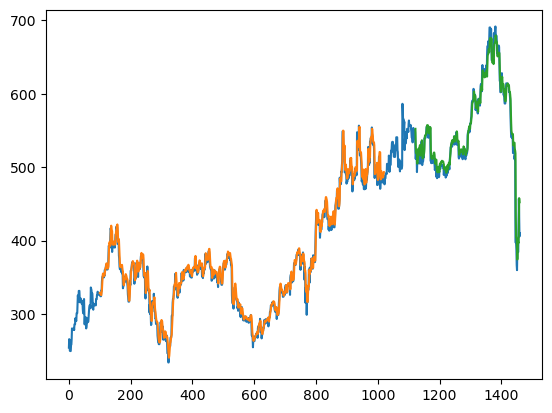

In [28]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()